Please use the following data set: https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv

- Personal time line is 2014 - 2015 and validation is 2016.
- Import and prepare the data as you are used to
- Build a small Autoencoder with an Encoder output dimension of 3
- Take a look at the top 10 and lowest 10 in terms of square root of squared errors, plot their normalized returns (each close price divided by the first close price) over the whole time period and calculate the correlation, what do you see ? 
- Build several different Autoencoder with 3,5,8,11 Encoder output dimensions, both linear and non-linear (therefore 8 in Total).
- Compare the constiuants of top 40 and lowest 40 companies in terms of square root of squared erros (for comparison calculate the percentage of matching companies). 

**Author: Ali Haydar Özdağ**

```
Personal time line is 2014 - 2015 and validation is 2016.
```


# STEP 2: Import and prepare the data as you are used to

In [318]:
import pandas as pd
url = 'https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv'
df = pd.read_csv(url)
df['date'] =  pd.to_datetime(df['date'], format="%Y-%m-%d")
df = df.set_index(['date'], drop=True)

df.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.123676,8.664290,4.9977,10.592284,14.556592,8.9131,13.007511,16.675596,493.513336,25.293035,...,9.802009,28.258766,22.608261,9.080934,12.959832,NaN,7.992623,9.964503,14.441016,3.740663
1998-01-05,0.120823,8.712471,5.0671,10.622808,14.753723,9.0913,12.912563,16.614594,490.152191,24.946089,...,9.705754,28.684456,22.389481,9.239215,13.083271,NaN,8.105922,9.878420,14.280560,3.628285
1998-01-06,0.144131,8.567928,5.2368,10.378607,14.784045,9.3587,12.722677,16.573921,488.191773,24.685869,...,9.609494,28.946413,22.644733,9.041370,13.165551,NaN,8.085321,9.738531,13.770018,3.475768
1998-01-07,0.133190,8.624138,5.1597,11.019638,14.586929,9.0457,12.608740,16.512913,483.429932,24.703232,...,9.449069,28.193266,22.498867,8.843530,13.124411,NaN,7.817531,9.641684,14.207628,3.467741
1998-01-08,0.138423,8.736559,5.2060,10.958587,14.526262,9.2540,12.456830,16.553585,480.909332,24.460360,...,9.609494,28.356985,21.878969,8.645684,12.939268,NaN,7.570335,9.663206,13.901303,3.331276


In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6270 entries, 1998-01-02 to 2022-11-30
Columns: 193 entries, AAPL to YUM
dtypes: float64(193)
memory usage: 9.3 MB


**All data types are the same. No need to do any conversion.**

In [320]:
df.isnull().sum()

AAPL       0
ABT        0
ADBE       0
ADM        0
ADP        0
        ... 
WRK     4396
WY         0
XEL        0
XOM        0
YUM        0
Length: 193, dtype: int64

**There is around 70% NAN data in the WRK column. This amount is too much.
I will drop this column first and exclude this company from the analysis. 
Then I will delete the rows with NAN values.**

In [321]:
df = df.drop('WRK', axis=1)
df = df.dropna()
df.isnull().sum()

AAPL    0
ABT     0
ADBE    0
ADM     0
ADP     0
       ..
WMT     0
WY      0
XEL     0
XOM     0
YUM     0
Length: 192, dtype: int64

**My personal time line is 2014 - 2015 and validation is 2016.**


In [322]:
train_df  = df.loc['2014-01-01':'2015-12-31']
val_df   = df.loc['2016-01-01':'2016-12-31']

train_df.info()
print("\n")
val_df.info()
print("\n")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2014-01-02 to 2015-12-31
Columns: 192 entries, AAPL to YUM
dtypes: float64(192)
memory usage: 759.9 KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Columns: 192 entries, AAPL to YUM
dtypes: float64(192)
memory usage: 380.0 KB




**A graphical view of the remaining data after preparing the dataset.**

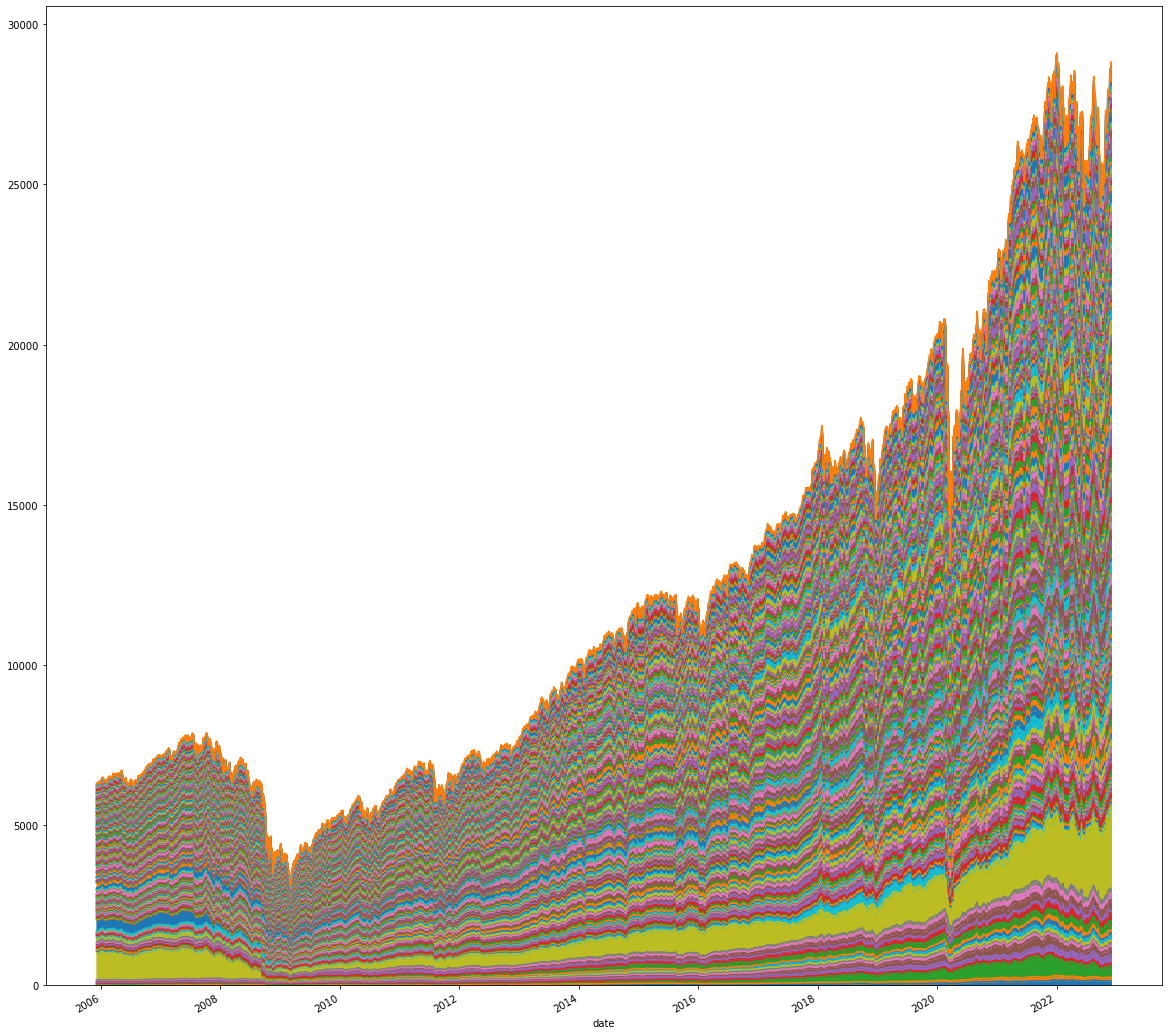

In [323]:
df.plot.area(legend=False,figsize=(20,20))

# STEP 3:Build a small Autoencoder with an Encoder output dimension of 3

In [324]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# normalize data for neural network usage
scaler = MinMaxScaler()
scaler.fit(train_df)  #train_df and val_df were defined in step2.
train_df_s, val_df_s = scaler.transform(train_df), scaler.transform(val_df)


# define encoder 
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_dim = (train_df_s.shape[1]), use_bias = False)
])

# define decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(train_df_s.shape[1], input_dim = (3), use_bias = False)
])

# define autoencoder with mean squared error as recreation loss
autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = 'Adam')
autoencoder.summary()

# stop training data if mse for validation does not get better
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
fit_autoencoder = autoencoder.fit(train_df_s, train_df_s, epochs = 500, callbacks = [my_callback], validation_data = (val_df_s, val_df_s))

Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_156 (Sequential)  (None, 3)                576       
                                                                 
 sequential_157 (Sequential)  (None, 192)              576       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 13ms/step - loss: 0.3163 - val_loss: 0.7641
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.2782 - val_loss: 0.6444
Epoch 3/500
16/16 [==============================] - 0s 6ms/step - loss: 0.2198 - val_loss: 0.5105
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1626 - val_loss: 0.4003
Epoch 5/500
16/16 [==============================

### Model Training Graphics


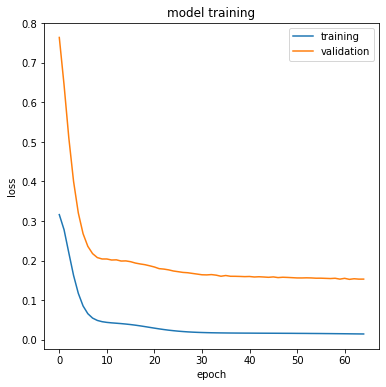

In [325]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6,6))

# summarize history for loss
plt.plot(fit_autoencoder.history['loss'], label="training")
plt.plot(fit_autoencoder.history['val_loss'], label="validation")
plt.title('model training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# STEP 4: Take a look at the top 10 and lowest 10 in terms of square root of squared errors, plot their normalized returns (each close price divided by the first close price) over the whole time period and calculate the correlation, what do you see ?

In [326]:
import numpy as np
# recreation of data 
X_train_hat = autoencoder.predict(train_df_s) 
X_val_hat = autoencoder.predict(val_df_s) 

# differences of original data and recreations 

Error_train = (train_df_s - X_train_hat) 
Error_val = (val_df_s - X_val_hat) 

error_train = pd.DataFrame(Error_train, columns = train_df.columns, index = train_df.index) 
error_val = pd.DataFrame(Error_val, columns = val_df.columns, index = val_df.index)

# square root of squared errors 
error_train_rsq = error_train.apply(lambda x: np.sqrt(x**2)) 
error_val_rsq = error_val.apply(lambda x: np.sqrt(x**2)) 

8/8 [==============================] - 0s 2ms/step


In [327]:
error_per_mean_company = error_val_rsq.mean(axis = 0)

# The 10 companies with at least quare root of squared errors.
first_ten_companies = error_per_mean_company.sort_values()[:10]
first_ten_companies 

ALL     0.053797
L       0.061233
ETN     0.070044
CAT     0.077086
APD     0.081784
YUM     0.084810
HD      0.086540
AZO     0.093081
CAG     0.093417
BALL    0.093506
dtype: float64

In [328]:
# The 10 companies with the most square root squared errors.
last_ten_companies = error_per_mean_company.sort_values()[-10:]
last_ten_companies  

C       0.686922
AXP     0.701250
BAC     0.714940
VZ      0.732502
LNC     0.738583
CINF    0.755387
AMD     0.820754
T       0.913724
NEM     0.938668
SYY     0.959998
dtype: float64

## Finding normalized returns

Top 10 companies

In [436]:
index_list = list(first_ten_companies.index.values) # set names of companies
normalized_df_top_10 = df.loc['2014-01-01':'2016-12-31']

#We exclude companies that are not in the top 10.
normalized_df_top_10 = normalized_df_top_10.filter(index_list) 

for key1 in index_list:
  val1 = normalized_df_top_10[key1][0]
  normalized_df_top_10[key1] = [x / val1 for x in normalized_df_top_10[key1]]

normalized_df_top_10

,ALL,L,ETN,CAT,APD,YUM,HD,AZO,CAG,BALL
date,,,,,,,,,,
2014-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,0.995892,0.997467,1.002914,0.999444,0.998026,1.006259,0.998415,1.002932,0.997617,1.004669
2014-01-06,0.991970,0.995356,0.998543,0.986313,1.000448,1.005460,0.988783,1.009829,0.992851,1.000973
2014-01-07,0.996265,0.991979,1.000663,0.989540,0.988065,1.019577,0.993660,1.019995,1.009830,1.012254
2014-01-08,0.999440,0.986914,0.997218,0.991877,0.987886,1.019177,0.998902,1.031554,1.001489,1.012254
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,1.474224,1.021515,0.998753,1.163989,1.517278,1.262453,1.752490,1.678556,1.647806,1.517266
2016-12-27,1.472840,1.020010,1.002118,1.166827,1.526601,1.266805,1.755215,1.694902,1.651121,1.522243
2016-12-28,1.469677,1.014635,0.990559,1.149551,1.503191,1.260672,1.752749,1.678703,1.638276,1.513086


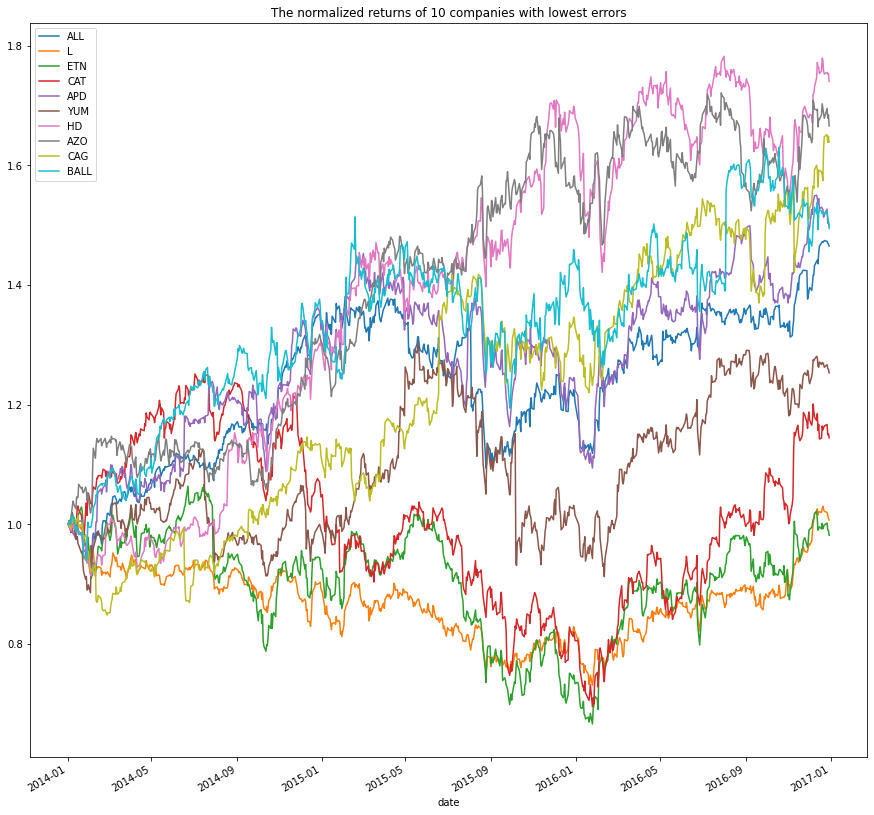

In [437]:
normalized_df_top_10.plot(figsize=(15,15),title= "The normalized returns of 10 companies with lowest errors")

 **Info:** *The definition of the top 10 companies refers to the 10 companies with the lowest errors.*

*   Among the top 10 companies, HD has become the company with the highest increase in close price value.

*   Except for 2-3 months after the start of the dataset, for 3 years, BAL,HD,APD never fell below the initial stock value ( or initial close price value).

*   Among the top 10 companies, ETN was the company whose close price value decreased the most.

*   Among the top 10 companies, there are only 2 companies whose close price value is below that of the first day of the data set on the last day of the data set: ETN (represented in green on the graph), L (represented in orange on the graph)

*  Company ETN had the lowest value in the range in the dataset on 2016-2.

*  One of the companies whose close price fluctuates the most is YUM.










In [438]:
normalized_df_top_10.corr()

,ALL,L,ETN,CAT,APD,YUM,HD,AZO,CAG,BALL
ALL,1.000000,-0.077321,0.033025,-0.159925,0.927704,0.633348,0.745697,0.663681,0.708100,0.867372
L,-0.077321,1.000000,0.830154,0.823328,-0.105519,0.075945,-0.436410,-0.476313,-0.304945,-0.217828
ETN,0.033025,0.830154,1.000000,0.786341,0.025068,0.283539,-0.418445,-0.429637,-0.311730,-0.110701
CAT,-0.159925,0.823328,0.786341,1.000000,-0.170707,0.006392,-0.600064,-0.625972,-0.451619,-0.250455
APD,0.927704,-0.105519,0.025068,-0.170707,1.000000,0.695942,0.785687,0.721721,0.737089,0.899188
YUM,0.633348,0.075945,0.283539,0.006392,0.695942,1.000000,0.591744,0.598473,0.700573,0.717901
HD,0.745697,-0.436410,-0.418445,-0.600064,0.785687,0.591744,1.000000,0.968418,0.930921,0.845033
AZO,0.663681,-0.476313,-0.429637,-0.625972,0.721721,0.598473,0.968418,1.000000,0.917427,0.778569
CAG,0.708100,-0.304945,-0.311730,-0.451619,0.737089,0.700573,0.930921,0.917427,1.000000,0.811147
BALL,0.867372,-0.217828,-0.110701,-0.250455,0.899188,0.717901,0.845033,0.778569,0.811147,1.000000


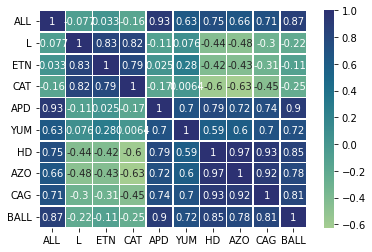

In [439]:
import seaborn as sns
sns.heatmap(normalized_df_top_10.corr(), cmap="crest", annot=True, linewidth=.5)

1.   The strongest correlation is found between AZO and HD with 0.97. The correlation direction is positive.(A value close to 1 means the strong correlation.)

2.   The weakest correlation is found between CAT and YUM with 0.0064. The correlation direction is positive. (A value close to 0 means the weak correlation.)

3.   The strongest negative correlation is found between AZO and CAT with -0.63.



**Last 10 companies**

In [333]:
index_list_2 = list(last_ten_companies.index.values)
normalized_df_last_10 = df.loc['2014-01-01':'2016-12-31']

#We exclude companies that are not in the last 10.
normalized_df_last_10 = normalized_df_last_10.filter(index_list_2)

for key2 in index_list_2:
  val2 = normalized_df_last_10[key2][0]
  normalized_df_last_10[key2] = [x1 / val2 for x1 in normalized_df_last_10[key2]]

normalized_df_last_10

,C,AXP,BAC,VZ,LNC,CINF,AMD,T,NEM,SYY
date,,,,,,,,,,
2014-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,1.021618,1.003242,1.019254,0.988163,1.005343,0.993780,1.012658,0.995708,0.998331,1.003619
2014-01-06,1.029462,1.002795,1.034782,0.993673,1.012666,0.991253,1.045570,1.000286,1.005008,1.002227
2014-01-07,1.036541,0.998994,1.024844,1.006122,1.019592,0.992226,1.058228,1.000000,0.999583,1.015590
2014-01-08,1.048594,1.002132,1.029814,1.000552,1.031504,0.989116,1.058228,0.997060,0.976628,1.001949
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,1.182023,0.875696,1.453599,1.254402,1.407720,1.651435,2.931646,1.506936,1.379802,1.698585
2016-12-27,1.183961,0.875813,1.454243,1.253467,1.407720,1.653162,3.055696,1.504114,1.385328,1.696772
2016-12-28,1.163612,0.868687,1.436233,1.248793,1.387102,1.639992,2.924051,1.499530,1.393404,1.683481


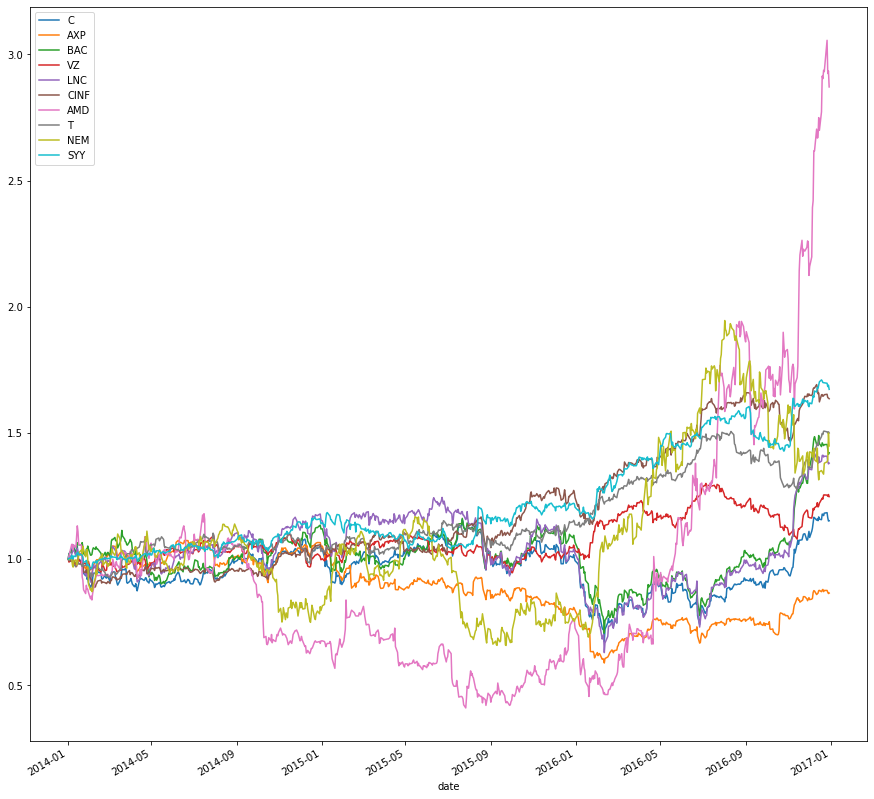

In [334]:
normalized_df_last_10.plot(figsize=(15,15),title= "The normalized returns of 10 companies with highest errors")

 **Info:** *The definition of the last 10 companies refers to the 10 companies with the highest errors.*

*   Among the last 10 companies, AMD has become the company with the highest increase in close price value.

*   AMD had the lowest value in the dataset in 2015-05 and 2015-09. Even so,it is the most valuable company on the last day of the dataset.

*   Also the company whose close price value changed the most was AMD.

*   Among the top 10 companies, there are only 1 company whose close price value is below that of the first day of the data set on the last day of the data set: SYY (represented in orange on the graph)

*   Company VZ was the company with the most stable closing price.

In [335]:
normalized_df_last_10.corr()

,C,AXP,BAC,VZ,LNC,CINF,AMD,T,NEM,SYY
C,1.000000,0.479944,0.856726,-0.350206,0.924565,-0.193745,0.056232,-0.291732,-0.350826,-0.199726
AXP,0.479944,1.000000,0.343814,-0.677418,0.500384,-0.772893,-0.127763,-0.745924,-0.448331,-0.703878
BAC,0.856726,0.343814,1.000000,-0.158083,0.860339,0.070471,0.422372,-0.039958,-0.114786,0.097449
VZ,-0.350206,-0.677418,-0.158083,1.000000,-0.240368,0.851032,0.560888,0.936572,0.809267,0.857532
LNC,0.924565,0.500384,0.860339,-0.240368,1.000000,-0.137457,0.218322,-0.215547,-0.192426,-0.112720
CINF,-0.193745,-0.772893,0.070471,0.851032,-0.137457,1.000000,0.624476,0.950778,0.738795,0.972470
AMD,0.056232,-0.127763,0.422372,0.560888,0.218322,0.624476,1.000000,0.636176,0.737389,0.673087
T,-0.291732,-0.745924,-0.039958,0.936572,-0.215547,0.950778,0.636176,1.000000,0.813429,0.945016
NEM,-0.350826,-0.448331,-0.114786,0.809267,-0.192426,0.738795,0.737389,0.813429,1.000000,0.752281
SYY,-0.199726,-0.703878,0.097449,0.857532,-0.112720,0.972470,0.673087,0.945016,0.752281,1.000000


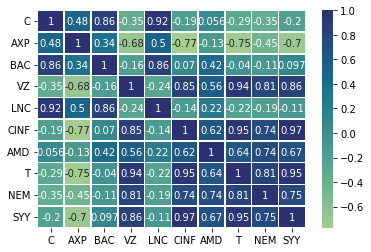

In [336]:
sns.heatmap(normalized_df_last_10.corr(), cmap="crest", annot=True, linewidth=.5)

1.   The strongest correlation is found between SYY and CINF with 0.97. The correlation direction is positive.(A value close to 1 means the strong correlation.)

2.   The weakest correlation is found between AMD and C with 0.056. The correlation direction is positive. (A value close to 0 means the weak correlation.)

3.   The strongest negative correlation is found between AXP and CINF with -0.77.



## Merging the top 10 companies list and the last 10 companies list.

*   The new list would be called as the 20 companies.
*   This list was created to compare the normalized value of all companies we have.



In [368]:
# index_list consists of data holding the names of the top 10 companies (lowest errors)
# index_list_2 consists of data holding the names of the last 10 companies (highest errors)
index_list_3 = index_list + index_list_2
#all personel dataset timeline
normalized_df_20 = df.loc['2014-01-01':'2016-12-31']

#We exclude companies that are not in the first 10 or are not in the last 10.
normalized_df_20 = normalized_df_20.filter(index_list_3)

for key3 in index_list_3:
  val3 = normalized_df_20[key3][0]
  normalized_df_20[key3] = [x3 / val3 for x3 in normalized_df_20[key3]]

normalized_df_20

,ALL,L,ETN,CAT,APD,YUM,HD,AZO,CAG,BALL,C,AXP,BAC,VZ,LNC,CINF,AMD,T,NEM,SYY
date,,,,,,,,,,,,,,,,,,,,
2014-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,0.995892,0.997467,1.002914,0.999444,0.998026,1.006259,0.998415,1.002932,0.997617,1.004669,1.021618,1.003242,1.019254,0.988163,1.005343,0.993780,1.012658,0.995708,0.998331,1.003619
2014-01-06,0.991970,0.995356,0.998543,0.986313,1.000448,1.005460,0.988783,1.009829,0.992851,1.000973,1.029462,1.002795,1.034782,0.993673,1.012666,0.991253,1.045570,1.000286,1.005008,1.002227
2014-01-07,0.996265,0.991979,1.000663,0.989540,0.988065,1.019577,0.993660,1.019995,1.009830,1.012254,1.036541,0.998994,1.024844,1.006122,1.019592,0.992226,1.058228,1.000000,0.999583,1.015590
2014-01-08,0.999440,0.986914,0.997218,0.991877,0.987886,1.019177,0.998902,1.031554,1.001489,1.012254,1.048594,1.002132,1.029814,1.000552,1.031504,0.989116,1.058228,0.997060,0.976628,1.001949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,1.474224,1.021515,0.998753,1.163989,1.517278,1.262453,1.752490,1.678556,1.647806,1.517266,1.182023,0.875696,1.453599,1.254402,1.407720,1.651435,2.931646,1.506936,1.379802,1.698585
2016-12-27,1.472840,1.020010,1.002118,1.166827,1.526601,1.266805,1.755215,1.694902,1.651121,1.522243,1.183961,0.875813,1.454243,1.253467,1.407720,1.653162,3.055696,1.504114,1.385328,1.696772
2016-12-28,1.469677,1.014635,0.990559,1.149551,1.503191,1.260672,1.752749,1.678703,1.638276,1.513086,1.163612,0.868687,1.436233,1.248793,1.387102,1.639992,2.924051,1.499530,1.393404,1.683481


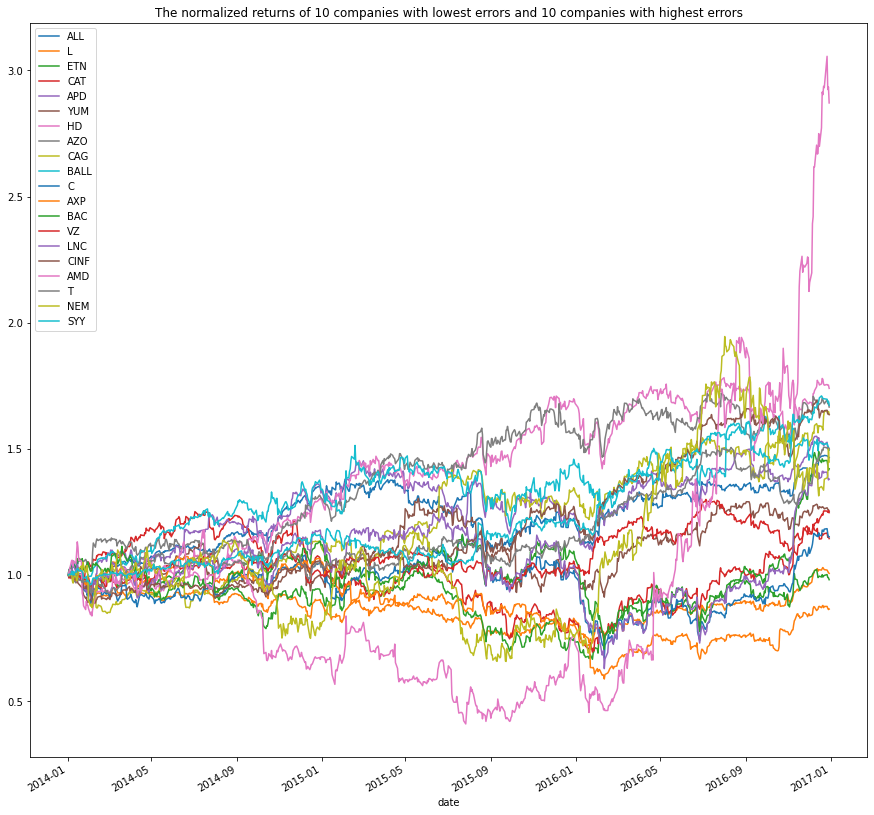

In [369]:
normalized_df_20.plot(figsize=(15,15),title= "The normalized returns of 10 companies with lowest errors and 10 companies with highest errors")

*   AMD has become the company with the highest increase in close price value.
*   AMD had the lowest value in the dataset in 2015-05 and 2015-09. Even so,it is the most valuable company on the last day of the dataset.
*   Also the company whose close price value changed the most was AMD.

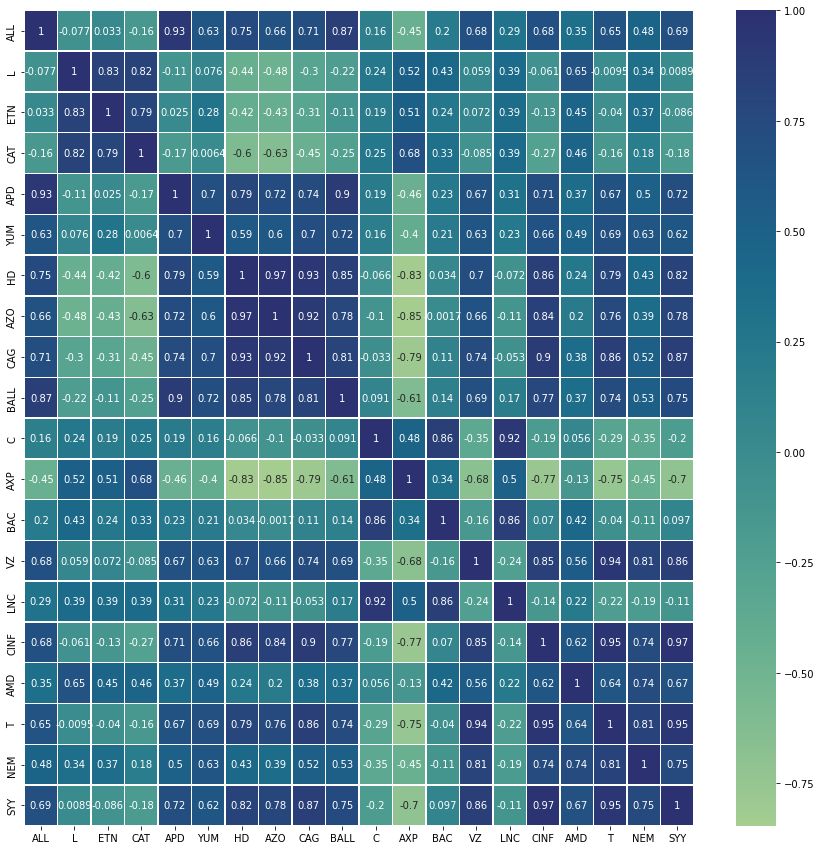

In [373]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(normalized_df_20.corr(), cmap="crest", annot=True, linewidth=.5, ax=ax)

1.   The strongest correlations are found between AZO and HD, also between SYY and CINF with 0.97. The correlation directions are positive.
2.   The weakest correlation is found between AZO and BAC with 0.0017.
3.   The strongest negative correlation is found between AXP and CINF with -0.77.





# STEP 5: Build several different Autoencoder with 3,5,8,11 Encoder output dimensions, both linear and non-linear (therefore 8 in Total).

Instead of writing the same code 16 times, I put the code blocks into the method.

In step 6, I use only the run_autoencoder_and_return_srse method.

This method first triggers the make_autoencoder method. First it creates the auto encoder model and runs it.

Then, It triggers the get_square_root_of_squared_error method with the necessary variables to find the square root of squared errors values.

Important note: train_df and val_df were created in step 2 and this data is not changed in any autoencoder step. So the analysis works correctly. The autoencoder uses the same main dataset for each request.

In [337]:
def get_square_root_of_squared_error(train_df_s,val_df_s,my_model_autoencoder):

  # recreation of data 
  X_train_hat = my_model_autoencoder.predict(train_df_s) 
  X_val_hat = my_model_autoencoder.predict(val_df_s) 

  # differences of original data and recreations 

  Error_train = (train_df_s - X_train_hat) 
  Error_val = (val_df_s - X_val_hat) 

  error_train = pd.DataFrame(Error_train, columns = train_df.columns, index = train_df.index) 
  error_val = pd.DataFrame(Error_val, columns = val_df.columns, index = val_df.index)

  # square root of squared errors 
  error_train_rsq = error_train.apply(lambda x: np.sqrt(x**2)) 
  error_val_rsq = error_val.apply(lambda x: np.sqrt(x**2)) 

  error_per_mean_company = error_val_rsq.mean(axis = 0)
  return error_per_mean_company

In [338]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def make_autoencoder(dense_input : int, activation_func : str):
  scaler = MinMaxScaler()
  scaler.fit(train_df)
  train_df_s, val_df_s = scaler.transform(train_df), scaler.transform(val_df)

  # define encoder 
  encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(dense_input, input_dim = (train_df_s.shape[1]), activation = activation_func, use_bias = False)
  ])

  # define decoder
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(train_df_s.shape[1], input_dim = (dense_input),activation = activation_func, use_bias = False)
  ])

  # define autoencoder with mean squared error as recreation loss
  autoencoder = tf.keras.Sequential([encoder, decoder])
  autoencoder.compile(loss = 'mse', optimizer = 'Adam')
  autoencoder.summary()

  # stop training data if mse for validation does not get better
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
  fit_autoencoder = autoencoder.fit(train_df_s, train_df_s, epochs = 500, callbacks = [my_callback], validation_data = (val_df_s, val_df_s))
  # return model
  return train_df_s, val_df_s, autoencoder

In [339]:
def run_autoencoder_and_return_srse(dense_input : int, activation_func : str):
  train_df_s, val_df_s, autoencoder = make_autoencoder(dense_input, activation_func)
  
  # When make autoencoder runs, it will print loss and val_loss values. I used the "-" expression to easily separate the logs of these 2 methods.
  print("-------------") 
  
  return get_square_root_of_squared_error(train_df_s, val_df_s, autoencoder)

# STEP 6: Compare the constiuants of top 40 and lowest 40 companies in terms of square root of squared erros (for comparison calculate the percentage of matching companies).

## Build autoencouders and find constituents of top 40 and lowest 40 companies in terms of square root of squared erros

In [385]:
linear_a3_srse = run_autoencoder_and_return_srse(3, 'linear')

Model: "sequential_185"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_183 (Sequential)  (None, 3)                576       
                                                                 
 sequential_184 (Sequential)  (None, 192)              576       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 14ms/step - loss: 0.3248 - val_loss: 0.8312
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2958 - val_loss: 0.7563
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2346 - val_loss: 0.6096
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1689 - val_loss: 0.4619
Epoch 5/500
16/16 [==============================

In [386]:
linear_a3_srse

AAPL    0.448717
ABT     0.522709
ADBE    0.210484
ADM     0.356950
ADP     0.083170
          ...   
WMT     0.157431
WY      0.211581
XEL     0.382773
XOM     0.137410
YUM     0.091803
Length: 192, dtype: float64

In [387]:
linear_a3_top_40_company = linear_a3_srse[:40]
linear_a3_last_40_company = linear_a3_srse[-40:]

In [388]:
linear_a5_srse = run_autoencoder_and_return_srse(5,'linear')

Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_186 (Sequential)  (None, 5)                960       
                                                                 
 sequential_187 (Sequential)  (None, 192)              960       
                                                                 
Total params: 1,920
Trainable params: 1,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 13ms/step - loss: 0.3504 - val_loss: 0.7808
Epoch 2/500
16/16 [==============================] - 0s 6ms/step - loss: 0.2846 - val_loss: 0.6642
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2150 - val_loss: 0.4879
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1458 - val_loss: 0.3474
Epoch 5/500
16/16 [==============================

In [389]:
linear_a5_top_40_company = linear_a5_srse[:40]
linear_a5_last_40_company = linear_a5_srse[-40:]

In [390]:
linear_a8_srse = run_autoencoder_and_return_srse(8,'linear')

Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_189 (Sequential)  (None, 8)                1536      
                                                                 
 sequential_190 (Sequential)  (None, 192)              1536      
                                                                 
Total params: 3,072
Trainable params: 3,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 12ms/step - loss: 0.3066 - val_loss: 0.7219
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2296 - val_loss: 0.5306
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1498 - val_loss: 0.3712
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0908 - val_loss: 0.2805
Epoch 5/500
16/16 [==============================

In [391]:
linear_a8_top_40_company = linear_a8_srse[:40]
linear_a8_last_40_company = linear_a8_srse[-40:]

In [392]:
linear_a11_srse = run_autoencoder_and_return_srse(11,'linear')

Model: "sequential_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_192 (Sequential)  (None, 11)               2112      
                                                                 
 sequential_193 (Sequential)  (None, 192)              2112      
                                                                 
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 14ms/step - loss: 0.3168 - val_loss: 0.7351
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2276 - val_loss: 0.4803
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1293 - val_loss: 0.3021
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0672 - val_loss: 0.2287
Epoch 5/500
16/16 [==============================

In [393]:
linear_a11_top_40_company = linear_a11_srse[:40]
linear_a11_last_40_company = linear_a11_srse[-40:]

In [394]:
non_linear_a3_srse = run_autoencoder_and_return_srse(3,'sigmoid')

Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_195 (Sequential)  (None, 3)                576       
                                                                 
 sequential_196 (Sequential)  (None, 192)              576       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 14ms/step - loss: 0.0656 - val_loss: 0.3017
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0651 - val_loss: 0.3016
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0646 - val_loss: 0.3014
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0635 - val_loss: 0.2997
Epoch 5/500
16/16 [==============================

In [395]:
non_linear_a3_top_40_company = non_linear_a3_srse[:40]
non_linear_a3_last_40_company = non_linear_a3_srse[-40:]

In [396]:
non_linear_a5_srse = run_autoencoder_and_return_srse(5,'sigmoid')

Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_198 (Sequential)  (None, 5)                960       
                                                                 
 sequential_199 (Sequential)  (None, 192)              960       
                                                                 
Total params: 1,920
Trainable params: 1,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 11ms/step - loss: 0.0655 - val_loss: 0.3015
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 0.2998
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0629 - val_loss: 0.2973
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0611 - val_loss: 0.2931
Epoch 5/500
16/16 [==============================

In [397]:
non_linear_a5_top_40_company = non_linear_a5_srse[:40]
non_linear_a5_last_40_company = non_linear_a5_srse[-40:]

In [398]:
non_linear_a8_srse = run_autoencoder_and_return_srse(8,'sigmoid')

Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_201 (Sequential)  (None, 8)                1536      
                                                                 
 sequential_202 (Sequential)  (None, 192)              1536      
                                                                 
Total params: 3,072
Trainable params: 3,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 11ms/step - loss: 0.0658 - val_loss: 0.3017
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 0.3024
Epoch 3/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0625 - val_loss: 0.3039
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0602 - val_loss: 0.3041
-------------
8/8 [==============================

In [399]:
non_linear_a8_top_40_company = non_linear_a8_srse[:40]
non_linear_a8_last_40_company = non_linear_a8_srse[-40:]

In [400]:
non_linear_a11_srse = run_autoencoder_and_return_srse(11,'sigmoid')

Model: "sequential_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_204 (Sequential)  (None, 11)               2112      
                                                                 
 sequential_205 (Sequential)  (None, 192)              2112      
                                                                 
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 11ms/step - loss: 0.0660 - val_loss: 0.3023
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0641 - val_loss: 0.3024
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0622 - val_loss: 0.3013
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0593 - val_loss: 0.2991
Epoch 5/500
16/16 [==============================

In [401]:
non_linear_a11_top_40_company = non_linear_a11_srse[:40]
non_linear_a11_last_40_company = non_linear_a11_srse[-40:]

## Compare the constiuants

### top 40 companies

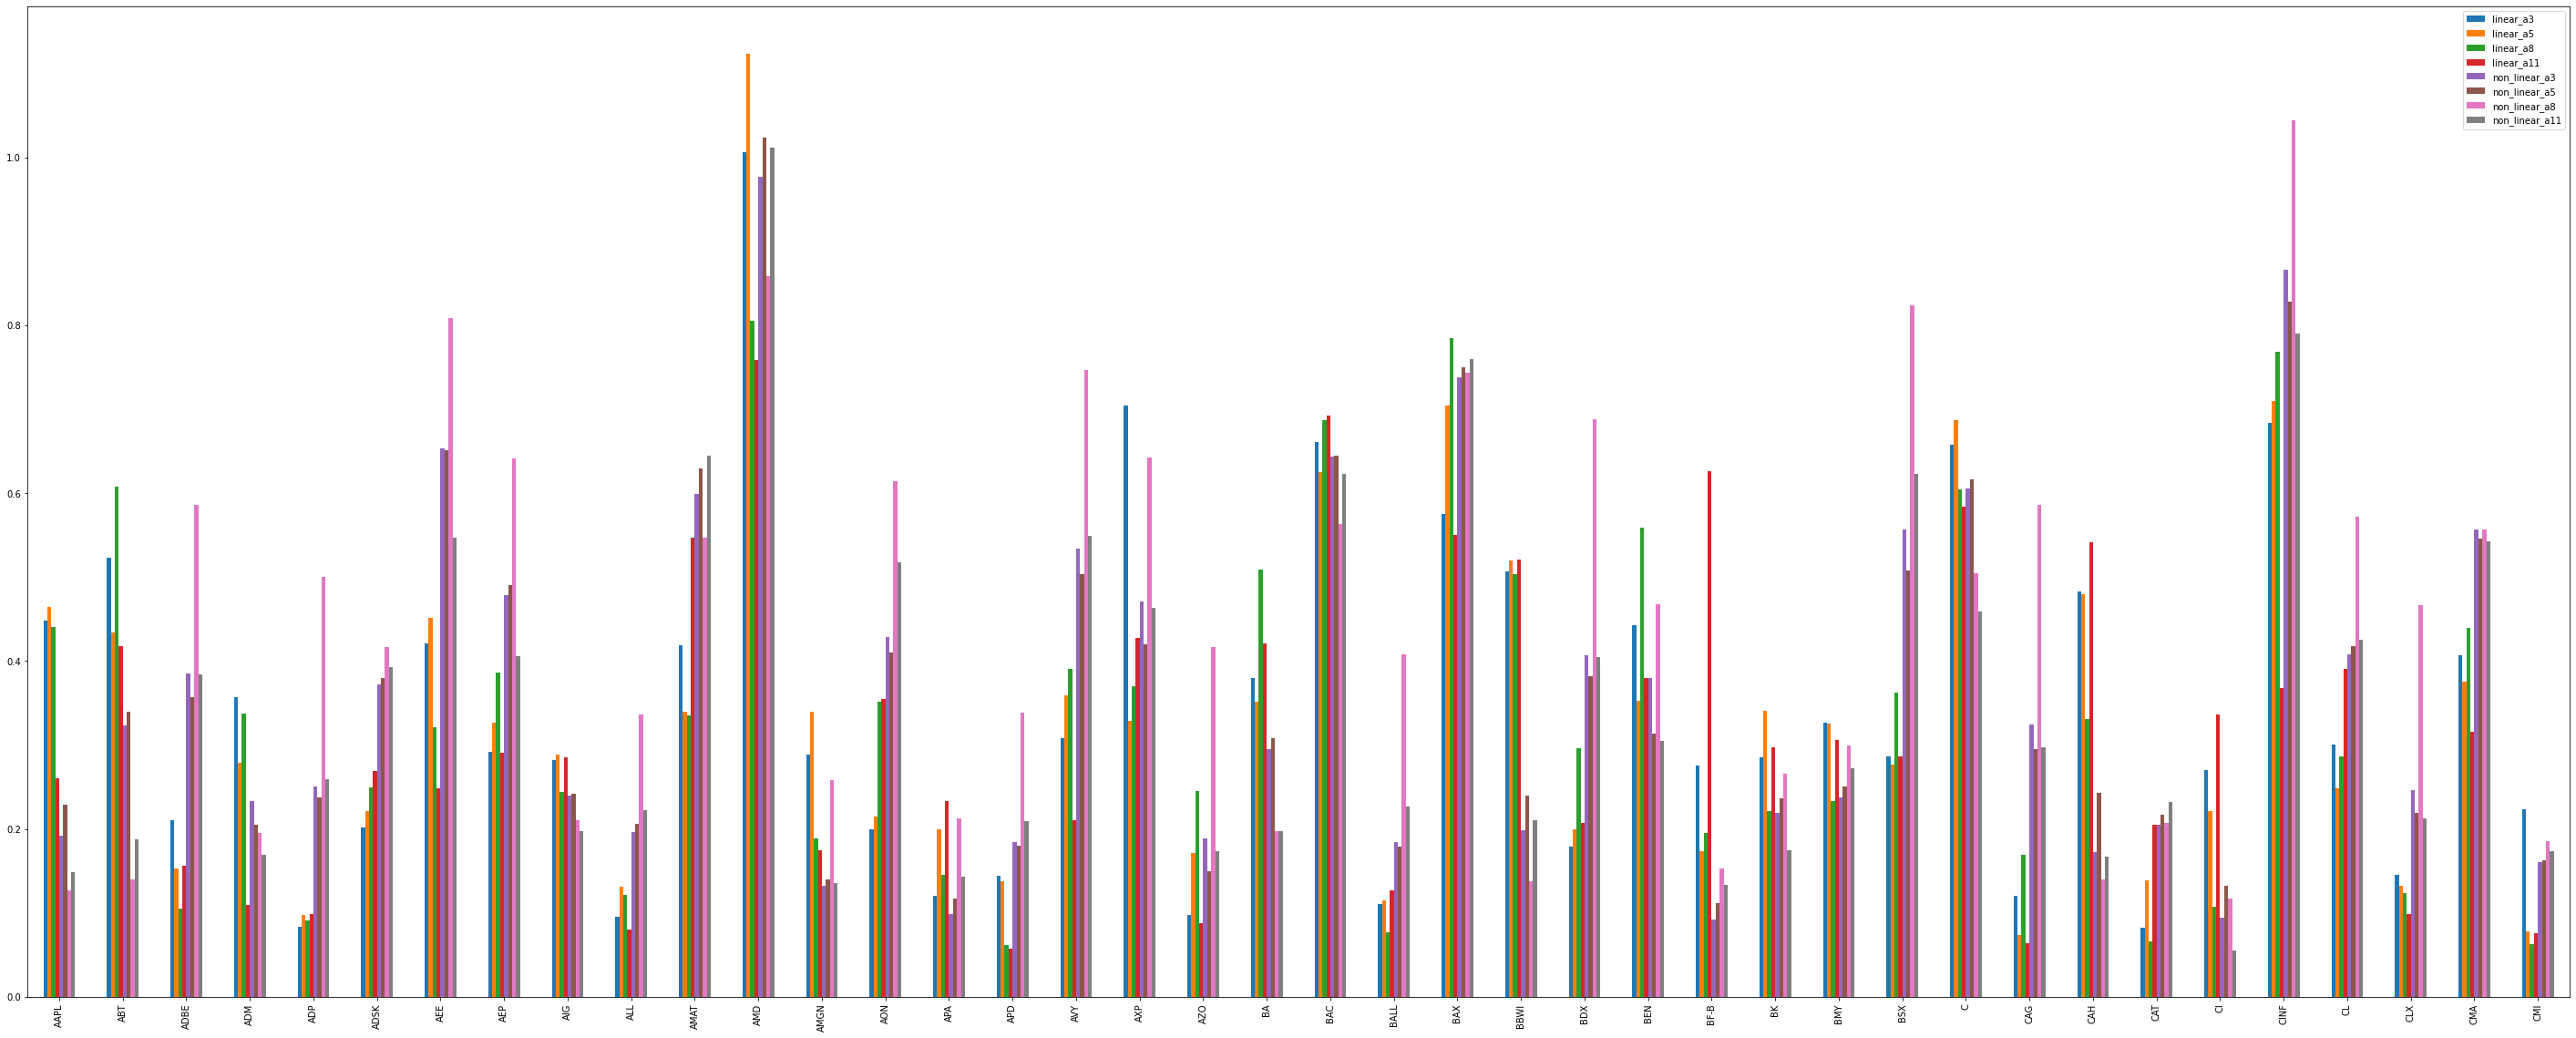

In [429]:
all_top_40_companies = pd.DataFrame([linear_a3_top_40_company, linear_a5_top_40_company, linear_a8_top_40_company, linear_a11_top_40_company,
                           non_linear_a3_top_40_company,non_linear_a5_top_40_company,non_linear_a8_top_40_company,non_linear_a11_top_40_company]).transpose()
all_top_40_companies.columns = ['linear_a3', 'linear_a5', 'linear_a8', 'linear_a11','non_linear_a3','non_linear_a5','non_linear_a8','non_linear_a11']
all_top_40_companies.plot.bar(figsize = (50, 20))


In [430]:
len(all_top_40_companies)

40

Despite combining all dataframes that calculate the top 40 companies, the total number of columns did not exceed 40.

This means that all autoencoder results are from the same companies.


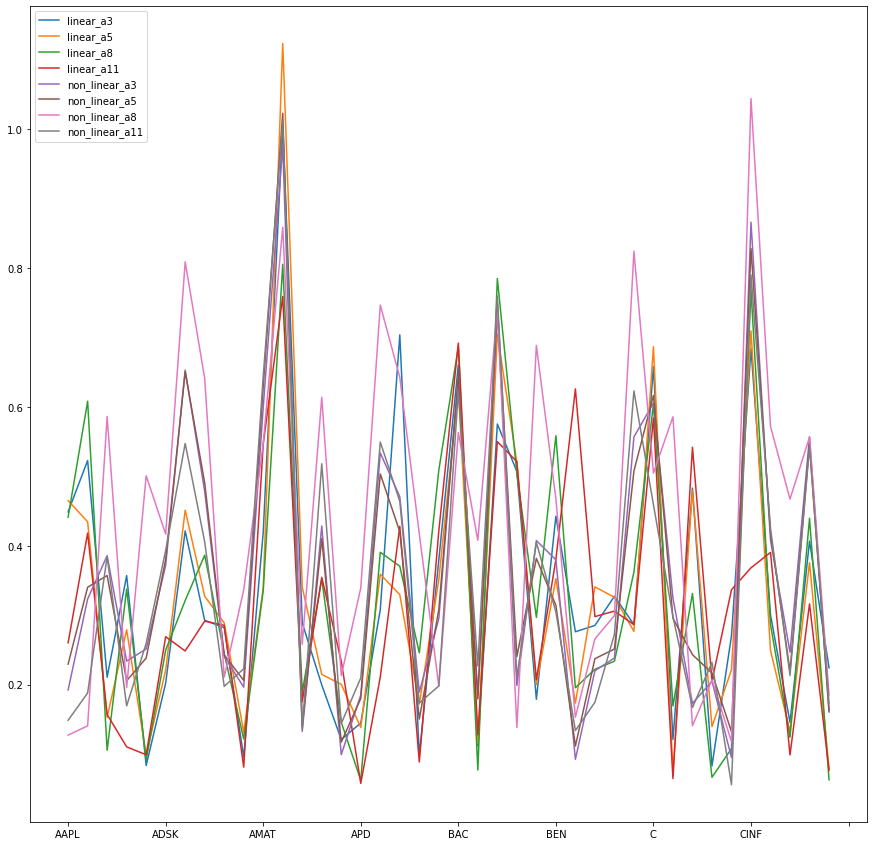

In [431]:
all_top_40_companies.plot(figsize=(15,15))

### Last 40 companies

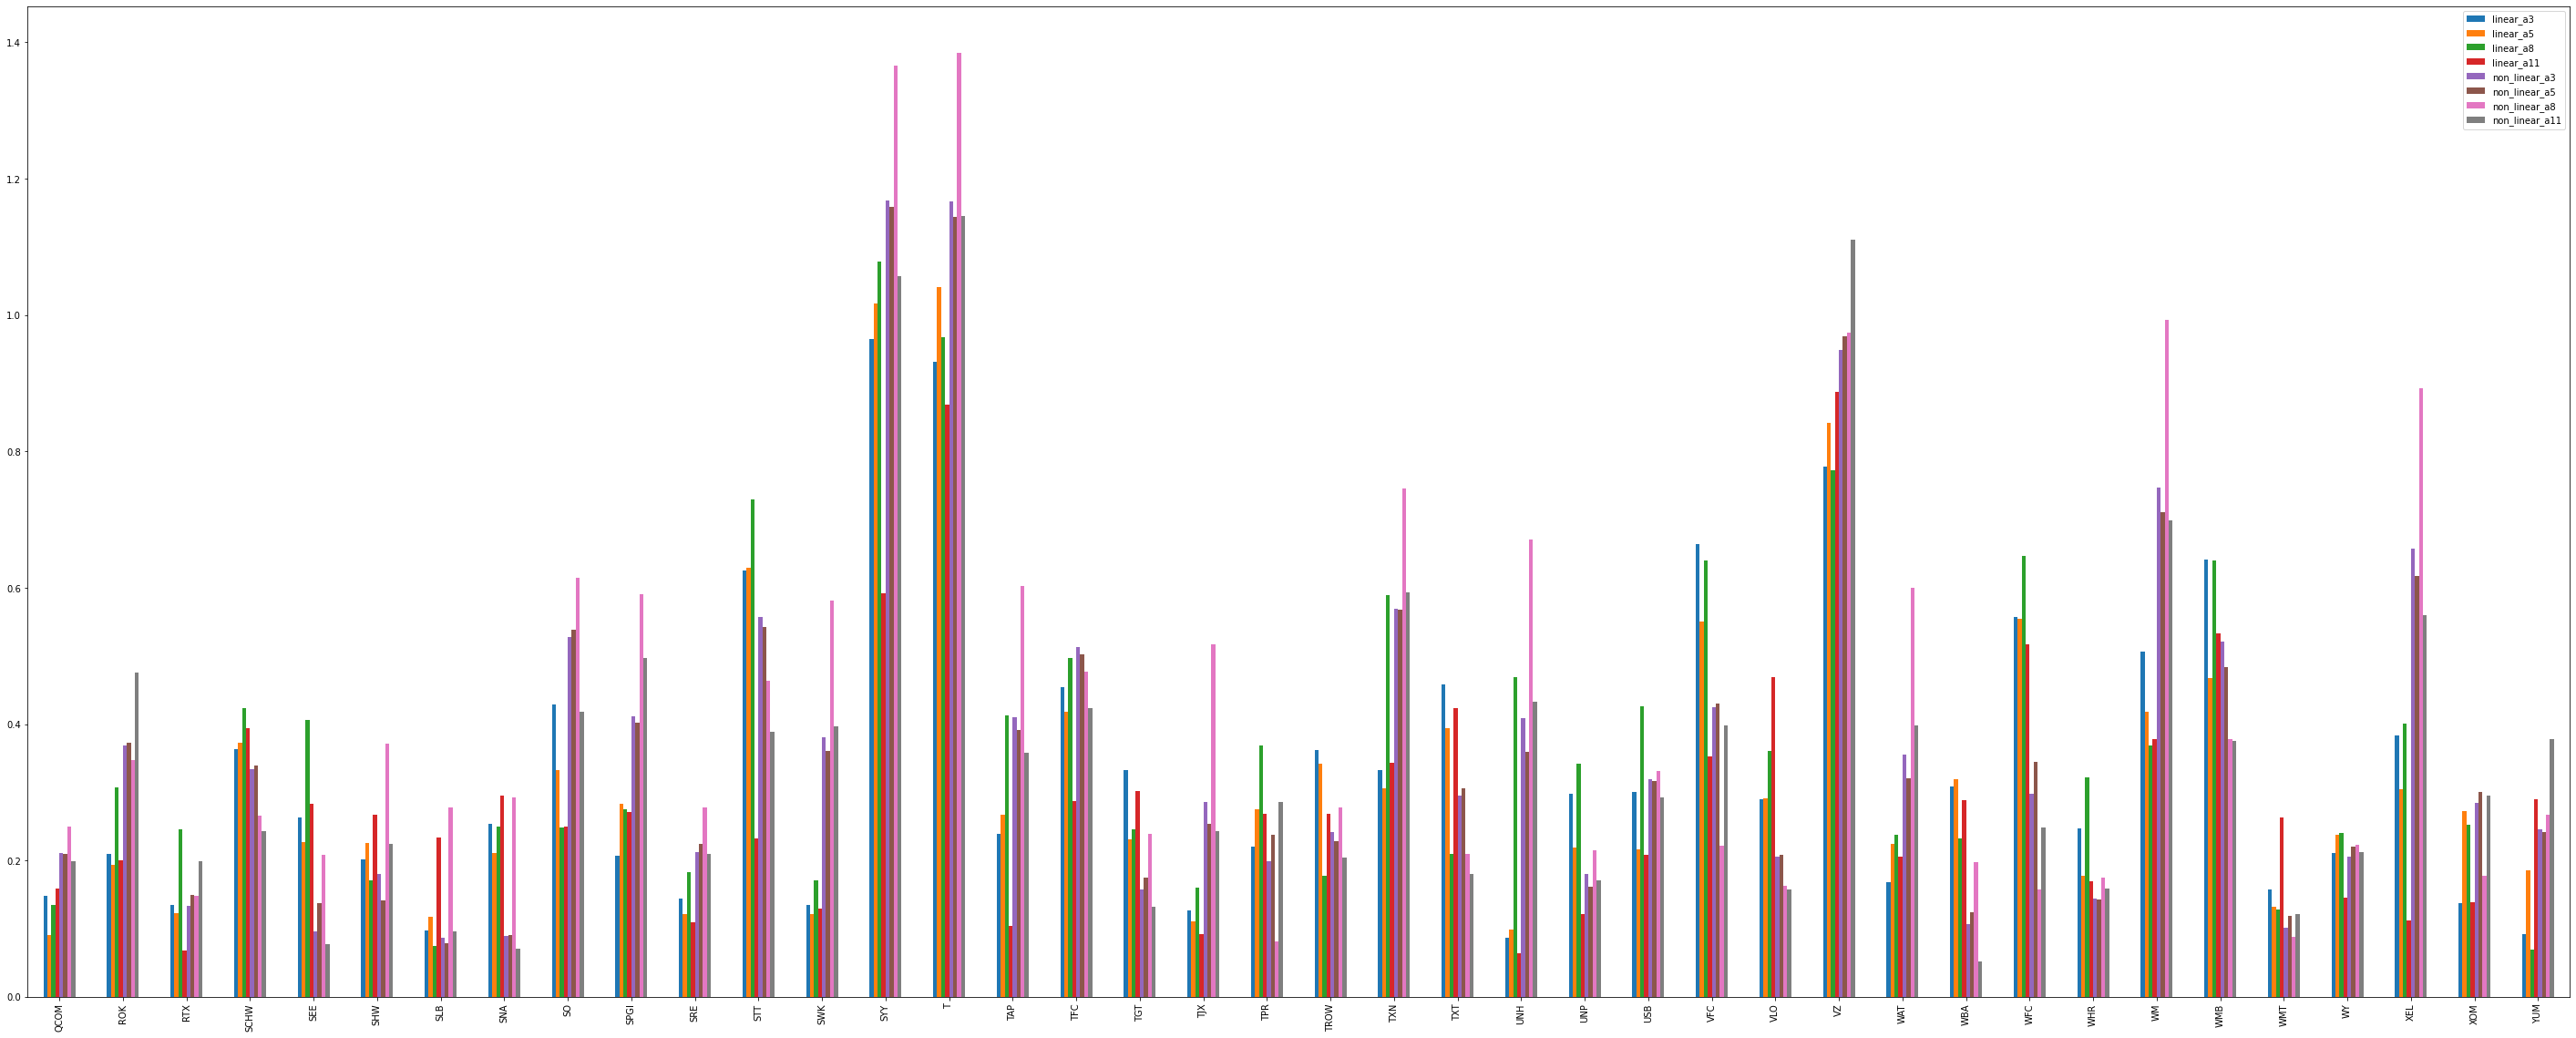

In [432]:
all_last_40_companies = pd.DataFrame([linear_a3_last_40_company, linear_a5_last_40_company, linear_a8_last_40_company, linear_a11_last_40_company,
                           non_linear_a3_last_40_company,non_linear_a5_last_40_company,non_linear_a8_last_40_company,non_linear_a11_last_40_company]).transpose()
all_last_40_companies.columns = ['linear_a3', 'linear_a5', 'linear_a8', 'linear_a11','non_linear_a3','non_linear_a5','non_linear_a8','non_linear_a11']
all_last_40_companies.plot.bar(figsize = (50, 20))

In [433]:
len(all_last_40_companies)

40

Despite combining all dataframes that calculate the last 40 companies, the total number of columns did not exceed 40.

This means that all autoencoder results are from the same companies.

In [434]:
all_last_40_companies

,linear_a3,linear_a5,linear_a8,linear_a11,non_linear_a3,non_linear_a5,non_linear_a8,non_linear_a11
QCOM,0.147846,0.090831,0.134905,0.159281,0.210480,0.209748,0.249177,0.199204
ROK,0.209901,0.194131,0.306647,0.199747,0.368984,0.373108,0.347588,0.475717
RTX,0.134454,0.122629,0.245989,0.068472,0.132765,0.148979,0.148681,0.198768
SCHW,0.363676,0.372923,0.423431,0.394044,0.333716,0.339523,0.265884,0.242849
SEE,0.262396,0.227069,0.406431,0.283611,0.095652,0.136963,0.207839,0.077630
SHW,0.201856,0.226198,0.170468,0.266610,0.180220,0.141039,0.371777,0.224812
SLB,0.096810,0.116731,0.074044,0.233293,0.087035,0.079152,0.277271,0.095867
SNA,0.253903,0.211287,0.250102,0.295424,0.089788,0.090620,0.291871,0.070131
SO,0.428681,0.332911,0.248605,0.249219,0.528333,0.538013,0.614329,0.417793
SPGI,0.206924,0.282862,0.274484,0.270471,0.411812,0.401547,0.590267,0.497571


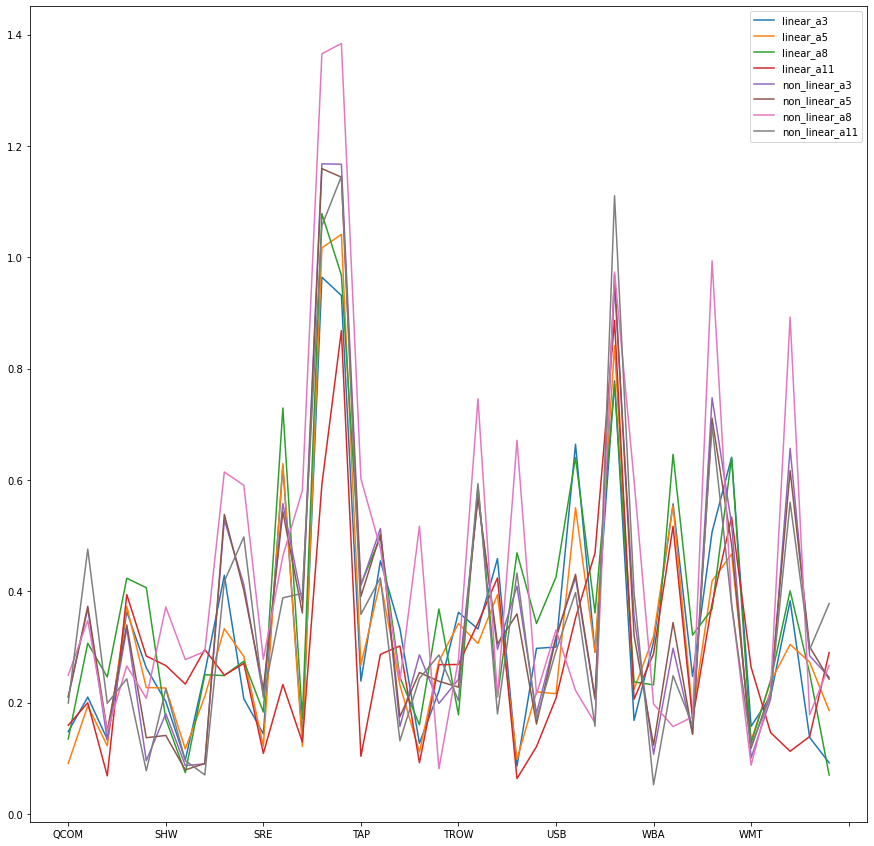

In [435]:
all_last_40_companies.plot(figsize=(15,15))